## To import the relevant functions
Put MCJulia.jl in a folder (or working directory), include that file via its relative path, then use the functions listed in the "export" statement of the MCJulia module. The dot in the using statement is required of local modules.

In [1]:
include("../src/MCJulia.jl") # or wherever you have the MCJulia.jl file
using .MCJulia  # imports the MCJulia exported namespace

# other useful packages for this demonstration
using PlotlyJS
using Statistics
using Printf
using LaTeXStrings

## Simple data fitting example: Fitting a line to noisy points. 
The example will readily generalize to any simple data fitting problem.

First generate the data. We will make a data set consisting of (x,y)
pairs of the form $y = ax + b + \text{noise}$. Importantly, we will treat $a,b$ **and the Gaussian noise scale** $\sigma$ as free parameters. 
These are the parameters used to generate the data:

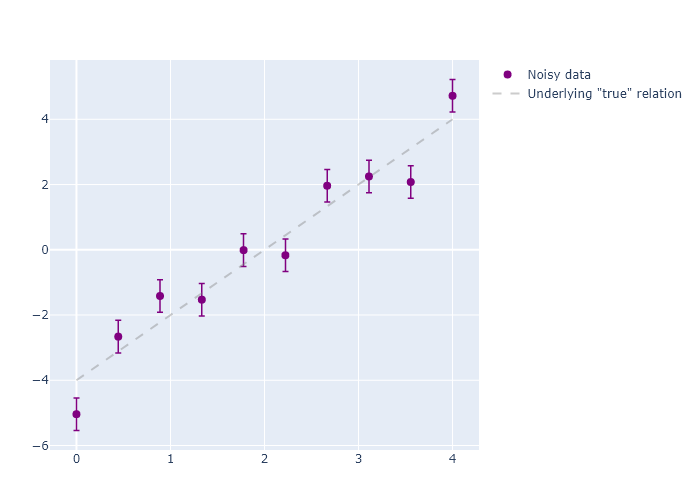

In [2]:
a = 2.0     # slope
b = -4.0    # intercept
sigma = 0.5     # noise sigma

# Generate ten data points evenly spaced in x
n_data = 10
X = collect(LinRange(0.0, 4.0, n_data))

# Generate some gaussian noise, create line
noise = randn(n_data)*sigma
Y = a*X .+ b .+ noise

data = scatter(
    x=X, y=Y,
    mode="markers",
    error_y=attr(
        type="constant",
        value = sigma,
        color="purple",
        thickness=1.5,
        width=3,
    ),
    marker=attr(color="purple", size=8),
    name="Noisy data"
)

line = scatter(
    x=X,
    y=a*X .+ b,
    mode="lines",
    name="Underlying \"true\" relation",
    line=attr(color="gray", dash="dash"),
    opacity=0.4
)

plot([data,line])


# Fitting
In a real application, everything above would come from the data. Now start the actual estimation process. For  derivation of the below likelihood see for example [this article](https://humberanalytics.com/Using-the-Maximum-Likelihood-Estimation-(MLE)-to-determine-a-linear-line-of-best-fit-to-noisy-data.html)


When fitting data, our likelihood function has the form 
$$\frac{1}{\sigma^n} \exp(-\chi^2/2)$$
where
$$\chi^2 = \sum_{i\in \text{data}} \left(\frac{\text{model }-\text{ data}_i}{\sigma_i}\right)^2 $$
and $n$ is the number of our data points and here $\sigma_i$ is a constant, $\sigma$. We use a wide normal prior distribution for a and b, and a Jeffreys prior p(x) ~= 1/x for sigma.
Our log-probability function has two extra arguments after the parameter vector,
giving the x and y values of the data points.

In [3]:
function log_probability(parameters::Array{Float64}, X_data::AbstractVector{Float64}, Y_data::AbstractVector{Float64})
	a = parameters[1]
	b = parameters[2]
	sigma = parameters[3]
	if sigma <= 0
		return -Inf
	end
	n = length(X_data)
	Y_model = a*X_data .+ b
	ChiSq = 0.5 * sum(((Y_model - Y_data)/sigma).^2)
	return -(n+1)*log(sigma) -ChiSq - (a/100.0)^2 - (b/100.0)^2
end

log_probability (generic function with 1 method)

In [4]:
# We give our data points to the sampler in the extra arguments tuple.
args = (X, Y)

# Set up the sampler. It is good to use a large number of walkers.
dim = 3
walkers = 100
S = Sampler(walkers, dim, log_probability, args)

Sampler(100, 3, log_probability, 2.0, Array{Float64, 3}(undef, 100, 3, 0), Matrix{Float64}(undef, 100, 0), 0, 0, ([0.0, 0.4444444444444444, 0.8888888888888888, 1.3333333333333333, 1.7777777777777777, 2.2222222222222223, 2.6666666666666665, 3.111111111111111, 3.5555555555555554, 4.0], [-5.039474445074861, -2.6615528081075044, -1.4155729937427388, -1.52967495658673, -0.011309382067313578, -0.1679618429409433, 1.9626487872546101, 2.2477056855809012, 2.076995599121255, 4.719823309955333]), Main.MCJulia.dummy_callback)

Generate starting positions for the walkers from a N(0,10)
distribution, squaring it for sigma. The ideal starting positions
will be in a spherical shell around the high-probability region, but
as long as they are close enough, the walkers will relax towards
the region fairly quickly.

In [5]:
p0 = randn((walkers, 3)) * 10
p0[:,3] = p0[:,3].^2 ;

## Run MCMC algorithm

In [6]:
# Do a burn-in of 200 steps (20000 samples). Discard the samples
# but keep the final position of the walkers. This is a small
# problem, so it's fast.
println("Burn-in...")
p = sample(S, p0, 200, 1, false)
println("acceptance ratio: $(S.accepted / S.iterations)")

# Start sample for another 1000 steps, saving the chain every 5
# steps, starting at the end position of the burn-in.
println("Sampling...")
sample(S, p, 1000, 5, true)
println("acceptance ratio: $(S.accepted / S.iterations)")

Burn-in...
Starting multi-threaded sampling on 4 threads
acceptance ratio: 0.5562408371669784
Sampling...
Starting multi-threaded sampling on 4 threads
acceptance ratio: 0.6206757098323363


Here we should in principle decorrelate the samples by keeping only one every $\tau$ steps from the chain, where $\tau$ is the autocorrelation time. We omit here for simplicity

In [13]:
a_posterior = flat_chain(S)[1,:]
b_posterior = flat_chain(S)[2,:]
sigma_posterior = flat_chain(S)[3,:];

quantile_list = [0.16, 0.5, 0.84];

# Establish estimates of parameters via median and expected error on these estimates
a_quantiles = quantile(a_posterior, quantile_list)
b_quantiles = quantile(b_posterior, quantile_list)
sigma_quantiles = quantile(sigma_posterior, quantile_list)

a_median = a_quantiles[2]
b_median = b_quantiles[2]
sigma_median = sigma_quantiles[2]

println(L"$\sigma$ estimaed quantiles", sigma_quantiles)
sigma_symmetric_uncertainty = ((sigma_quantiles[3] - sigma_quantiles[2]) + (sigma_quantiles[2] - sigma_quantiles[1]))/2
println("Symmetric uncertainty = $(sigma_symmetric_uncertainty)")

$\sigma$ estimaed quantiles[0.6192240266774801, 0.7775091577924491, 1.031037131086012]
Symmetric uncertainty = 0.20590655220426596


## Plot results

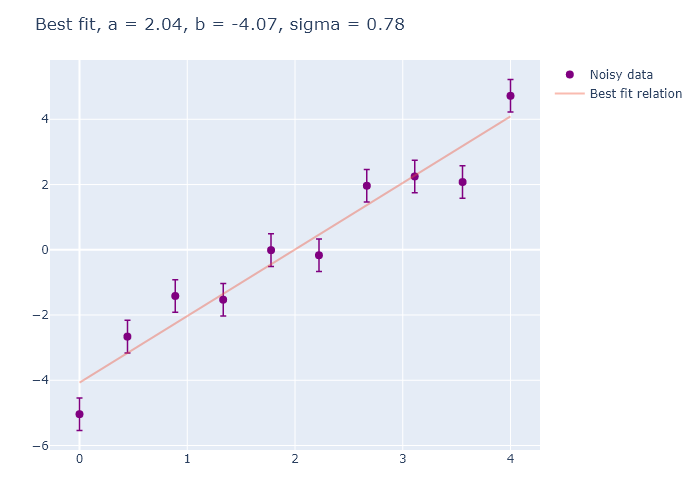

In [19]:
data = scatter(
    x=X, y=Y,
    mode="markers",
    error_y=attr(
        type="constant",
        value = sigma,
        color="purple",
        thickness=1.5,
        width=3,
    ),
    marker=attr(color="purple", size=8),
    name="Noisy data"
)

line = scatter(
    x=X,
    y=a_median*X .+ b_median,
    mode="lines",
    name="Best fit relation",
    #line=attr(color=""),
    opacity=0.4
)

plot([data,line],
    Layout(title="Best fit, a = $(@sprintf("%.2f", a_median)), b = $(@sprintf("%.2f", b_median)), sigma = $(@sprintf("%.2f", sigma_median))")
)

In [20]:
# Save the chain.
println("Saving chain...")
save_chain(S, "line_fit")

Saving chain...


## To view the corner plot, see view_results.ipynb